In [ ]:
#Basic libraries
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

#Framework
import torch
import torchvision

#data and its management related libraries
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets, models
import torchvision.transforms as transforms
from PIL import Image #python imaging library
import cv2

#for creating neural networks
import torch.nn as nn
import torch.nn.functional as F

#for optimising neural networks
import torch.optim as optim

#for metrics and analysis
import sklearn
from torchsummary import summary

# for dataset loading
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Setting Device for PyTorch

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device in Use:",device)

Device in Use: cuda


In [ ]:
torch.manual_seed(42) # Setting the seed

Loading and Preprocessing the Dataset

In [ ]:
# Load the dataset
california = fetch_california_housing()
X, y = california.data, california.target
print(X.shape, y.shape)

# Convert to pandas DataFrame for easier manipulation
columns = california.feature_names + ['MedHouseVal']
df = pd.DataFrame(data=np.c_[X, y], columns=columns)

# Preview the first few rows of the DataFrame
print(df.head())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Before Standardization:")
print(X_train[:3])
print(y_train[:3])

(20640, 8) (20640,)
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  
Before Standardization:
[[ 3.25960000e+00  3.30000000e+01  5.01765650e+00  1.00642055e+00
   2.30000000e+03  3.69181380e+00  3.27100000e+01 -1.17030000e+02]
 [ 3.81250000e+00  4.90000000e+01  4.47354497e+00  1.04100529e+00
   1.31400000e+03  1.73809524e+00  3.37700000e+01 -1.18160000e+02]
 [ 4.15630000e+00  4.00000000e+00  5.64583333e+00  9.85119048e-01

In [ ]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nAfter Standardization:")
print(X_train_scaled[:3])

# Convert the scaled arrays back to pandas DataFrame
X_train_scaled_df = pd.DataFrame(data=X_train_scaled, columns=california.feature_names)
X_test_scaled_df = pd.DataFrame(data=X_test_scaled, columns=california.feature_names)

# Preview the scaled training data
print(X_train_scaled_df.head())


After Standardization:
[[-0.326196    0.34849025 -0.17491646 -0.20836543  0.76827628  0.05137609
  -1.3728112   1.27258656]
 [-0.03584338  1.61811813 -0.40283542 -0.12853018 -0.09890135 -0.11736222
  -0.87669601  0.70916212]
 [ 0.14470145 -1.95271028  0.08821601 -0.25753771 -0.44981806 -0.03227969
  -0.46014647 -0.44760309]]
     MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0 -0.326196  0.348490 -0.174916  -0.208365    0.768276  0.051376 -1.372811   
1 -0.035843  1.618118 -0.402835  -0.128530   -0.098901 -0.117362 -0.876696   
2  0.144701 -1.952710  0.088216  -0.257538   -0.449818 -0.032280 -0.460146   
3 -1.017864  0.586545 -0.600015  -0.145156   -0.007434  0.077507 -1.382172   
4 -0.171488  1.142008  0.349007   0.086624   -0.485877 -0.068832  0.532084   

   Longitude  
0   1.272587  
1   0.709162  
2  -0.447603  
3   1.232698  
4  -0.108551  


Conversion to Torch Tensors

In [ ]:
# Convert to torch tensors
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape for consistency in dimensions
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

print("\nAfter Converting to Torch Tensor:")
print(X_train_torch.shape, y_train_torch.shape)
print(X_train_torch[:3])
print(y_train_torch[:3])


After Converting to Torch Tensor:
torch.Size([16512, 8]) torch.Size([16512, 1])
tensor([[-0.3262,  0.3485, -0.1749, -0.2084,  0.7683,  0.0514, -1.3728,  1.2726],
        [-0.0358,  1.6181, -0.4028, -0.1285, -0.0989, -0.1174, -0.8767,  0.7092],
        [ 0.1447, -1.9527,  0.0882, -0.2575, -0.4498, -0.0323, -0.4601, -0.4476]])
tensor([[1.0300],
        [3.8210],
        [1.7260]])


*Creating* DataLoaders

In [ ]:
# Create TensorDatasets for training and testing data
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

# Define batch size
batch_size = 32

# Create DataLoaders for training and testing data
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the neural network with 2 hidden layers

In [ ]:
class RegressionNet(nn.Module):
    def __init__(self):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 64)  # Input layer
        self.fc2 = nn.Linear(64, 32) # Hidden layer
        self.fc3 = nn.Linear(32, 1)  # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Apply ReLU activation after first layer
        x = F.relu(self.fc2(x))  # Apply ReLU activation after second layer
        x = self.fc3(x)          # No activation function for the final layer
        return x


In [ ]:
# Create an instance of the network
net = RegressionNet()
net = net.to(device)
# Print the neural network's architecture
print(net)

RegressionNet(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [ ]:
for name, param in net.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter fc1.weight, shape torch.Size([64, 8])
Parameter fc1.bias, shape torch.Size([64])
Parameter fc2.weight, shape torch.Size([32, 64])
Parameter fc2.bias, shape torch.Size([32])
Parameter fc3.weight, shape torch.Size([1, 32])
Parameter fc3.bias, shape torch.Size([1])


In [ ]:
summary(net, input_size=(8,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             576
            Linear-2                   [-1, 32]           2,080
            Linear-3                    [-1, 1]              33
Total params: 2,689
Trainable params: 2,689
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


# Learning Rate Scheduler & Early Stopping

In [ ]:
from torch.optim.lr_scheduler import StepLR
lr_history = []

epochs = 30

def train_and_evaluate_regression(model, learning_rate, trainloader, testloader, epochs=epochs, early_stopping_patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.1)  # Learning rate scheduler

    # Lists for saving history
    train_loss_history = []
    val_loss_history = []

    early_stopping_counter = 0
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        total = 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device).view(-1, 1)  # Ensure labels are the correct shape
            optimizer.zero_grad()  # Zeroing the Gradients
            outputs = model(inputs) # Forward Pass
            loss = criterion(outputs, labels) # Computing the Loss
            loss.backward() # Backward Pass
            optimizer.step() # Updating the Model Parameters
            running_loss += loss.item()
            total += inputs.size(0)

        train_loss = running_loss / total
        train_loss_history.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device).view(-1, 1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                total += inputs.size(0)

        val_loss /= total
        val_loss_history.append(val_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        scheduler.step()  # Update the learning rate
        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)
        print(f'Updated learning rate after epoch {epoch+1}: {current_lr:.6f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break

    return train_loss_history, val_loss_history

In [ ]:
# Initialize the model
net = RegressionNet()
net = net.to(device)
# Define learning rates to test
learning_rates = [0.01]

# Placeholder for results
results = {}

# Train the model with different learning rates and store the results
for lr in learning_rates:
    print(f'Training with learning rate: {lr}')
    train_loss, val_loss = train_and_evaluate_regression(net, lr, trainloader, testloader)
    results[lr] = {
        'train_loss': train_loss,
        'val_loss': val_loss
        }

Training with learning rate: 0.01
Epoch [1/30], Train Loss: 0.0175, Validation Loss: 0.0181
Updated learning rate after epoch 1: 0.001000
Epoch [2/30], Train Loss: 0.0121, Validation Loss: 0.0120
Updated learning rate after epoch 2: 0.000100
Epoch [3/30], Train Loss: 0.0115, Validation Loss: 0.0118
Updated learning rate after epoch 3: 0.000010
Epoch [4/30], Train Loss: 0.0115, Validation Loss: 0.0118
Updated learning rate after epoch 4: 0.000001
Epoch [5/30], Train Loss: 0.0115, Validation Loss: 0.0118
Updated learning rate after epoch 5: 0.000000
Epoch [6/30], Train Loss: 0.0115, Validation Loss: 0.0118
Updated learning rate after epoch 6: 0.000000
Epoch [7/30], Train Loss: 0.0115, Validation Loss: 0.0118
Updated learning rate after epoch 7: 0.000000
Epoch [8/30], Train Loss: 0.0115, Validation Loss: 0.0118
Updated learning rate after epoch 8: 0.000000
Epoch [9/30], Train Loss: 0.0115, Validation Loss: 0.0118
Updated learning rate after epoch 9: 0.000000
Epoch [10/30], Train Loss: 0.0

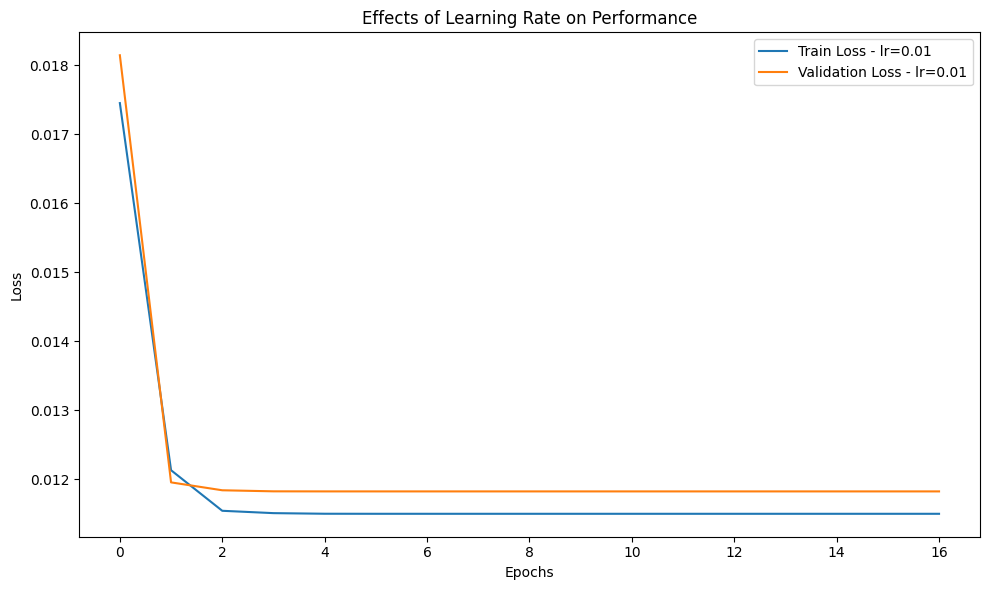

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))
plt.title('Effects of Learning Rate on Performance')

for lr, result in results.items():
    plt.plot(result['train_loss'], label=f'Train Loss - lr={lr}')
    plt.plot(result['val_loss'], label=f'Validation Loss - lr={lr}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_and_evaluate_regression(model, learning_rate, trainloader, testloader, epochs=epochs, early_stopping_patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    # Lists for saving history
    train_loss_history = []
    val_loss_history = []
    lr_history = []

    early_stopping_counter = 0
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        total = 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device).view(-1, 1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            total += inputs.size(0)

        train_loss = running_loss / total
        train_loss_history.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device).view(-1, 1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                total += inputs.size(0)

        val_loss /= total
        val_loss_history.append(val_loss)

        # Print the current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Current LR: {current_lr:.6f}')

        # Step with ReduceLROnPlateau
        scheduler.step(val_loss)

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break

    return train_loss_history, val_loss_history, lr_history


In [ ]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define learning rates to test
learning_rates = [0.01]

# Placeholder for results
results = {}

# Train the model with different learning rates and store the results
for lr in learning_rates:
    print(f'Training with learning rate: {lr}')
    # Initialize a new instance of the model for each learning rate
    net = RegressionNet()
    net = net.to(device)

    # Train and evaluate the model
    train_loss, val_loss, lr_history = train_and_evaluate_regression(net, lr, trainloader, testloader)

    # Store the results
    results[lr] = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'lr_history': lr_history
    }


Training with learning rate: 0.01
Epoch [1/30], Train Loss: 0.0171, Validation Loss: 0.0127, Current LR: 0.010000
Epoch [2/30], Train Loss: 0.0124, Validation Loss: 0.0114, Current LR: 0.010000
Epoch [3/30], Train Loss: 0.0114, Validation Loss: 0.0113, Current LR: 0.010000
Epoch [4/30], Train Loss: 0.0112, Validation Loss: 0.0136, Current LR: 0.010000
Epoch [5/30], Train Loss: 0.0107, Validation Loss: 0.0103, Current LR: 0.010000
Epoch [6/30], Train Loss: 0.0103, Validation Loss: 0.0100, Current LR: 0.010000
Epoch [7/30], Train Loss: 0.0103, Validation Loss: 0.0101, Current LR: 0.010000
Epoch [8/30], Train Loss: 0.0099, Validation Loss: 0.0103, Current LR: 0.010000
Epoch [9/30], Train Loss: 0.0098, Validation Loss: 0.0093, Current LR: 0.010000
Epoch [10/30], Train Loss: 0.0097, Validation Loss: 0.0100, Current LR: 0.010000
Epoch [11/30], Train Loss: 0.0096, Validation Loss: 0.0096, Current LR: 0.010000
Epoch [12/30], Train Loss: 0.0095, Validation Loss: 0.0095, Current LR: 0.010000
Epo

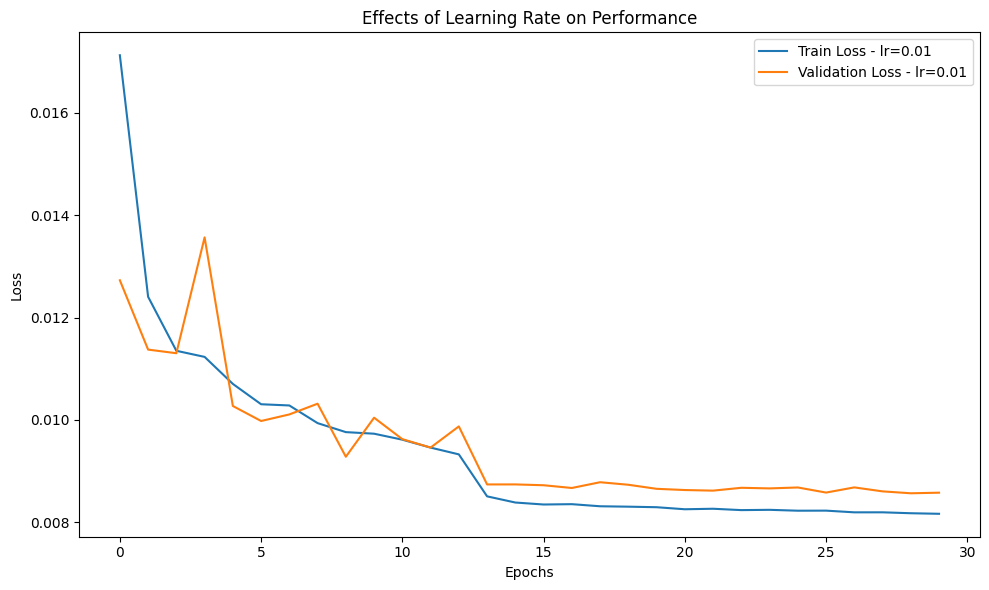

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))
plt.title('Effects of Learning Rate on Performance')

for lr, result in results.items():
    plt.plot(result['train_loss'], label=f'Train Loss - lr={lr}')
    plt.plot(result['val_loss'], label=f'Validation Loss - lr={lr}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


# Gradient Descent: Full-batch/Vanilla GD, Stochastic GD, Mini-batch GD

In [ ]:
def update_weights(params, gradients, lr):
    with torch.no_grad():  # Perform operations without tracking gradients
        for param, gradient in zip(params, gradients):
            param -= lr * gradient

def optimizer_step(model, loss_fn, inputs, labels, lr, batch_size=None):
    # Zero the gradients
    model.zero_grad()
    # Compute the forward pass
    outputs = model(inputs)
    # Calculate loss
    loss = loss_fn(outputs, labels)
    # Backward pass to get gradients
    loss.backward()

    # Get gradients for all parameters
    gradients = [param.grad for param in model.parameters()]

    # Update weights
    update_weights(model.parameters(), gradients, lr)

In [ ]:
def train(model, train_dataset, test_dataset, epochs, lr, batch_size=None):

    loss_fn = nn.MSELoss()  # Change to Mean Squared Error Loss for regression
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss = 0.0
        total = 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            if batch_size is None:
                # Vanilla GD
                current_batch_size = len(labels)
                print(current_batch_size)
            elif batch_size == 1:
                # SGD
                current_batch_size = 1
                print(current_batch_size)
            else:
                # Mini-batch GD
                current_batch_size = min(batch_size, len(labels))
                print(current_batch_size)

            optimizer_step(model, loss_fn, inputs, labels, lr, current_batch_size)

            # Calculate training loss
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item() * inputs.size(0)  # Multiply by batch size for correct scaling
            total += inputs.size(0)

        avg_train_loss = total_loss / total
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item() * inputs.size(0)  # Multiply by batch size for correct scaling
                total += inputs.size(0)

        avg_val_loss = val_loss / total
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses

In [ ]:
net = RegressionNet()
net = net.to(device)

full_batch_size = len(train_dataset)  # This should be the total number of examples in your training dataset

# Create DataLoaders for training and testing data using the full batch size
trainloader = DataLoader(train_dataset, batch_size=full_batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=full_batch_size, shuffle=False)

# Full batch GD
full_batch_metrics = train(net, trainloader, testloader, epochs=30, lr=0.01, batch_size=None)

16512
Epoch 1/30, Training Loss: 4.4081, Validation Loss: 4.3242
16512
Epoch 2/30, Training Loss: 4.1344, Validation Loss: 4.0513
16512
Epoch 3/30, Training Loss: 3.8720, Validation Loss: 3.7903
16512
Epoch 4/30, Training Loss: 3.6206, Validation Loss: 3.5405
16512
Epoch 5/30, Training Loss: 3.3803, Validation Loss: 3.3023
16512
Epoch 6/30, Training Loss: 3.1520, Validation Loss: 3.0765
16512
Epoch 7/30, Training Loss: 2.9366, Validation Loss: 2.8642
16512
Epoch 8/30, Training Loss: 2.7354, Validation Loss: 2.6664
16512
Epoch 9/30, Training Loss: 2.5491, Validation Loss: 2.4840
16512
Epoch 10/30, Training Loss: 2.3785, Validation Loss: 2.3177
16512
Epoch 11/30, Training Loss: 2.2240, Validation Loss: 2.1677
16512
Epoch 12/30, Training Loss: 2.0855, Validation Loss: 2.0341
16512
Epoch 13/30, Training Loss: 1.9625, Validation Loss: 1.9164
16512
Epoch 14/30, Training Loss: 1.8543, Validation Loss: 1.8135
16512
Epoch 15/30, Training Loss: 1.7599, Validation Loss: 1.7242
16512
Epoch 16/30, 

In [ ]:
net = RegressionNet()
net = net.to(device)
# Stochastic GD
sgd_metrics = train(net, trainloader, testloader, epochs=30, lr=0.01, batch_size=1)

1
Epoch 1/30, Training Loss: 5.4206, Validation Loss: 5.3352
1
Epoch 2/30, Training Loss: 5.0622, Validation Loss: 4.9818
1
Epoch 3/30, Training Loss: 4.7283, Validation Loss: 4.6526
1
Epoch 4/30, Training Loss: 4.4137, Validation Loss: 4.3424
1
Epoch 5/30, Training Loss: 4.1151, Validation Loss: 4.0480
1
Epoch 6/30, Training Loss: 3.8307, Validation Loss: 3.7675
1
Epoch 7/30, Training Loss: 3.5598, Validation Loss: 3.5003
1
Epoch 8/30, Training Loss: 3.3024, Validation Loss: 3.2464
1
Epoch 9/30, Training Loss: 3.0592, Validation Loss: 3.0064
1
Epoch 10/30, Training Loss: 2.8310, Validation Loss: 2.7811
1
Epoch 11/30, Training Loss: 2.6189, Validation Loss: 2.5715
1
Epoch 12/30, Training Loss: 2.4241, Validation Loss: 2.3787
1
Epoch 13/30, Training Loss: 2.2471, Validation Loss: 2.2031
1
Epoch 14/30, Training Loss: 2.0883, Validation Loss: 2.0453
1
Epoch 15/30, Training Loss: 1.9473, Validation Loss: 1.9050
1
Epoch 16/30, Training Loss: 1.8235, Validation Loss: 1.7819
1
Epoch 17/30, Tr

In [ ]:
net = RegressionNet()
net = net.to(device)
# Mini-batch GD with batch size of, for example, 64
mini_batch_metrics = train(net, trainloader, testloader, epochs=30, lr=0.01, batch_size=64)

64
Epoch 1/30, Training Loss: 4.8376, Validation Loss: 4.7628
64
Epoch 2/30, Training Loss: 4.5328, Validation Loss: 4.4584
64
Epoch 3/30, Training Loss: 4.2499, Validation Loss: 4.1757
64
Epoch 4/30, Training Loss: 3.9828, Validation Loss: 3.9092
64
Epoch 5/30, Training Loss: 3.7279, Validation Loss: 3.6549
64
Epoch 6/30, Training Loss: 3.4828, Validation Loss: 3.4103
64
Epoch 7/30, Training Loss: 3.2465, Validation Loss: 3.1743
64
Epoch 8/30, Training Loss: 3.0189, Validation Loss: 2.9469
64
Epoch 9/30, Training Loss: 2.8008, Validation Loss: 2.7289
64
Epoch 10/30, Training Loss: 2.5934, Validation Loss: 2.5215
64
Epoch 11/30, Training Loss: 2.3984, Validation Loss: 2.3263
64
Epoch 12/30, Training Loss: 2.2175, Validation Loss: 2.1449
64
Epoch 13/30, Training Loss: 2.0514, Validation Loss: 1.9782
64
Epoch 14/30, Training Loss: 1.9009, Validation Loss: 1.8268
64
Epoch 15/30, Training Loss: 1.7663, Validation Loss: 1.6911
64
Epoch 16/30, Training Loss: 1.6474, Validation Loss: 1.5710
6

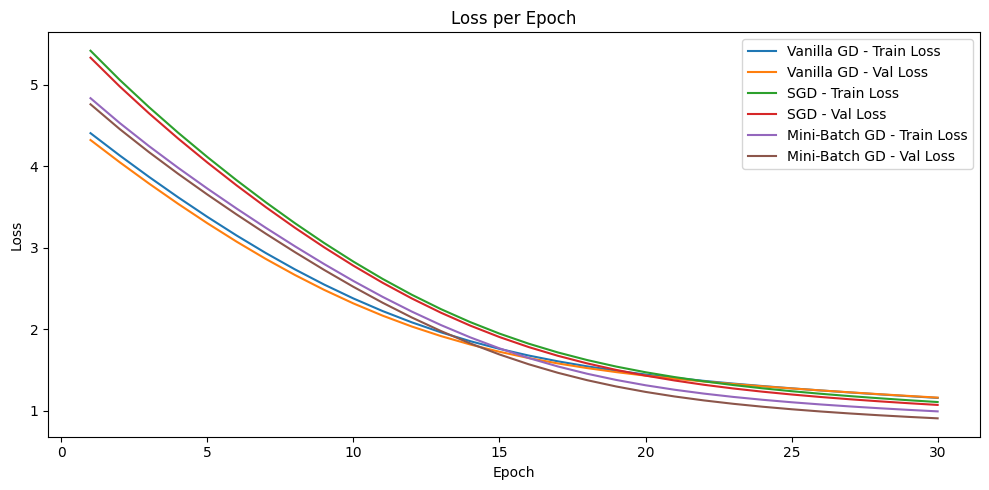

In [ ]:
# Visualization code to plot only losses
def plot_loss_curves(*metrics, labels):
    plt.figure(figsize=(10, 5))

    for metric, label in zip(metrics, labels):
        train_losses, val_losses = metric
        epochs = range(1, len(train_losses) + 1)

        plt.plot(epochs, train_losses, label=f'{label} - Train Loss')
        plt.plot(epochs, val_losses, label=f'{label} - Val Loss')

    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Plot the learning curves
plot_loss_curves(
    full_batch_metrics,
    sgd_metrics,
    mini_batch_metrics,
    labels=['Vanilla GD', 'SGD', 'Mini-Batch GD']
)


# Momentum based GDs

In [ ]:
class MomentumOptimizer:
    def __init__(self, parameters, lr=0.01, momentum=0.9):
        self.parameters = list(parameters)
        self.lr = lr
        self.momentum = momentum
        self.velocities = [torch.zeros_like(p) for p in self.parameters]

    def zero_grad(self):
        for p in self.parameters:
            if p.grad is not None:
                p.grad.zero_()

    def step(self):
        with torch.no_grad():
            for p, v in zip(self.parameters, self.velocities):
                if p.grad is not None:
                    v.mul_(self.momentum).add_(p.grad, alpha=self.lr)
                    p.sub_(v)

In [ ]:
def train_model(model, train_loader, test_loader, optimizer, epochs=20):
    loss_fn = nn.MSELoss()
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, total_samples = 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)  # Ensure proper target shape
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

        train_losses.append(total_loss / total_samples)

        model.eval()
        total_val_loss, total_val_samples = 0, 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)  # Ensure proper target shape
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)

                total_val_loss += loss.item() * inputs.size(0)
                total_val_samples += inputs.size(0)

        val_losses.append(total_val_loss / total_val_samples)

    return train_losses, val_losses

In [ ]:
# Initialize the model and optimizer for each gradient descent method with momentum
methods = ['Full Batch GD with Momentum', 'SGD with Momentum', 'Mini-Batch GD with Momentum']
batch_sizes = [len(trainloader.dataset), 1, 32]  # Example batch sizes for full, SGD, and mini-batch

results = {}
for method, batch_size in zip(methods, batch_sizes):
    print(f"Training using {method}...")
    net = RegressionNet().to(device)
    # Adjust DataLoader for full batch if necessary
    if batch_size == len(trainloader.dataset):
        print(batch_size)
        full_batch_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        optimizer = MomentumOptimizer(net.parameters(), lr=0.01, momentum=0.9)
        results[method] = train_model(net, full_batch_train_loader, testloader, optimizer, epochs=20)
    else:
        print(batch_size)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        optimizer = MomentumOptimizer(net.parameters(), lr=0.01, momentum=0.9)
        results[method] = train_model(net, trainloader, testloader, optimizer, epochs=20)


Training using Full Batch GD with Momentum...
16512
Training using SGD with Momentum...
1
Training using Mini-Batch GD with Momentum...
32


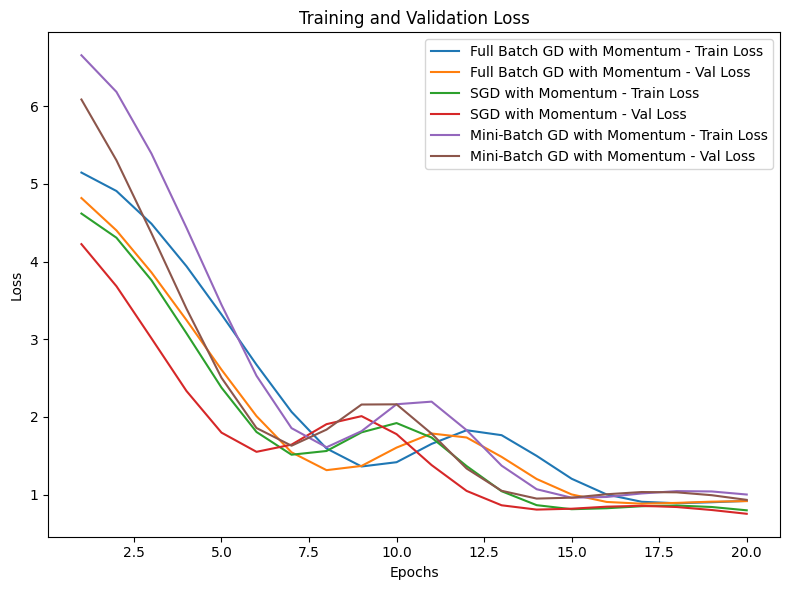

In [ ]:
def plot_loss(results):
    plt.figure(figsize=(8, 6))

    for method, metrics in results.items():
        train_losses, val_losses = metrics
        epochs = range(1, len(train_losses) + 1)
        plt.plot(epochs, train_losses, label=f'{method} - Train Loss')
        plt.plot(epochs, val_losses, label=f'{method} - Val Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot only the loss
plot_loss(results)


# AdagradOptimizer

In [ ]:
class AdagradOptimizer:
    def __init__(self, parameters, lr=0.01, epsilon=1e-10):
        self.parameters = list(parameters)
        self.lr = lr
        self.epsilon = epsilon
        self.squared_gradients = [torch.zeros_like(p) for p in self.parameters]

    def zero_grad(self):
        for p in self.parameters:
            if p.grad is not None:
                p.grad.zero_()

    def step(self):
        with torch.no_grad():
            for p, squared_gradient in zip(self.parameters, self.squared_gradients):
                if p.grad is not None:
                    squared_gradient.add_(p.grad ** 2)
                    adjusted_lr = self.lr / (torch.sqrt(squared_gradient + self.epsilon))
                    p.sub_(p.grad * adjusted_lr)


# RMSpropOptimizer

In [ ]:
class RMSpropOptimizer:
    def __init__(self, parameters, lr=0.01, alpha=0.9, epsilon=1e-10):
        self.parameters = list(parameters)
        self.lr = lr
        self.alpha = alpha
        self.epsilon = epsilon
        self.squared_gradients = [torch.zeros_like(p) for p in self.parameters]

    def zero_grad(self):
        for p in self.parameters:
            if p.grad is not None:
                p.grad.zero_()

    def step(self):
        with torch.no_grad():
            for p, squared_gradient in zip(self.parameters, self.squared_gradients):
                if p.grad is not None:
                    squared_gradient.mul_(self.alpha).add_(p.grad ** 2 * (1 - self.alpha))
                    adjusted_lr = self.lr / (torch.sqrt(squared_gradient + self.epsilon))
                    p.sub_(p.grad * adjusted_lr)


In [ ]:
def train_model(model, train_loader, test_loader, epochs, optimizer):
    loss_fn = nn.MSELoss()
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss, total_samples = 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)  # Reshape targets if necessary
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

        train_losses.append(total_loss / total_samples)

        # Validation phase
        model.eval()
        total_val_loss, total_val_samples = 0, 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)  # Reshape targets if necessary
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)

                total_val_loss += loss.item() * inputs.size(0)
                total_val_samples += inputs.size(0)

        val_losses.append(total_val_loss / total_val_samples)

        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    return train_losses, val_losses


In [ ]:
# Train using Adagrad
net_adagrad = RegressionNet()
net_adagrad = net_adagrad.to(device)
optimizer_adagrad = AdagradOptimizer(net_adagrad.parameters(), lr=0.01)
adagrad_metrics = train_model(net_adagrad, trainloader, testloader, epochs=30, optimizer=optimizer_adagrad)

Epoch 1/30, Training Loss: 5.7509, Validation Loss: 4.4506
Epoch 2/30, Training Loss: 4.5278, Validation Loss: 3.6902
Epoch 3/30, Training Loss: 3.7456, Validation Loss: 3.0523
Epoch 4/30, Training Loss: 3.0829, Validation Loss: 2.5115
Epoch 5/30, Training Loss: 2.5214, Validation Loss: 2.0630
Epoch 6/30, Training Loss: 2.0552, Validation Loss: 1.7045
Epoch 7/30, Training Loss: 1.6854, Validation Loss: 1.4316
Epoch 8/30, Training Loss: 1.4071, Validation Loss: 1.2299
Epoch 9/30, Training Loss: 1.2033, Validation Loss: 1.0836
Epoch 10/30, Training Loss: 1.0568, Validation Loss: 0.9792
Epoch 11/30, Training Loss: 0.9537, Validation Loss: 0.9039
Epoch 12/30, Training Loss: 0.8814, Validation Loss: 0.8491
Epoch 13/30, Training Loss: 0.8309, Validation Loss: 0.8083
Epoch 14/30, Training Loss: 0.7941, Validation Loss: 0.7798
Epoch 15/30, Training Loss: 0.7675, Validation Loss: 0.7584
Epoch 16/30, Training Loss: 0.7477, Validation Loss: 0.7428
Epoch 17/30, Training Loss: 0.7325, Validation Lo

In [ ]:
# Train using RMSprop
net_rmsprop = RegressionNet()
net_rmsprop = net_rmsprop.to(device)
optimizer_rmsprop = RMSpropOptimizer(net_rmsprop.parameters(), lr=0.01)
rmsprop_metrics = train_model(net_rmsprop, trainloader, testloader, epochs=30, optimizer=optimizer_rmsprop)

Epoch 1/30, Training Loss: 6.7313, Validation Loss: 3.3833
Epoch 2/30, Training Loss: 3.4505, Validation Loss: 1.5255
Epoch 3/30, Training Loss: 1.5176, Validation Loss: 1.0016
Epoch 4/30, Training Loss: 0.9665, Validation Loss: 0.8537
Epoch 5/30, Training Loss: 0.8259, Validation Loss: 0.7854
Epoch 6/30, Training Loss: 0.7634, Validation Loss: 0.7411
Epoch 7/30, Training Loss: 0.7207, Validation Loss: 0.7048
Epoch 8/30, Training Loss: 0.6878, Validation Loss: 0.6996
Epoch 9/30, Training Loss: 0.6786, Validation Loss: 0.7934
Epoch 10/30, Training Loss: 0.7826, Validation Loss: 1.0467
Epoch 11/30, Training Loss: 1.0149, Validation Loss: 1.1810
Epoch 12/30, Training Loss: 1.1802, Validation Loss: 0.6535
Epoch 13/30, Training Loss: 0.6337, Validation Loss: 0.6185
Epoch 14/30, Training Loss: 0.6034, Validation Loss: 0.5952
Epoch 15/30, Training Loss: 0.5738, Validation Loss: 0.5764
Epoch 16/30, Training Loss: 0.5604, Validation Loss: 0.5676
Epoch 17/30, Training Loss: 0.5466, Validation Lo

In [ ]:
def plot_losses(train_losses, val_losses, label):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label=f'{label} - Train Loss')
    plt.plot(epochs, val_losses, label=f'{label} - Val Loss')

    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

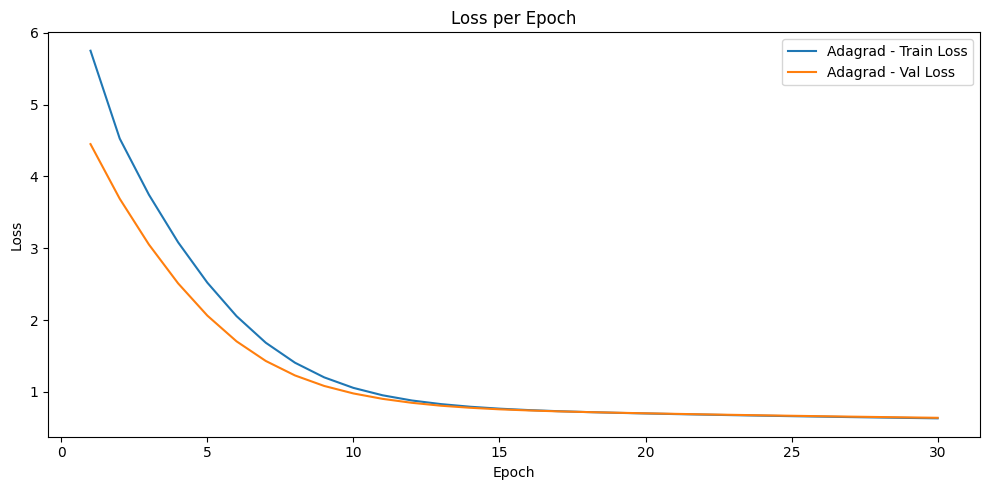

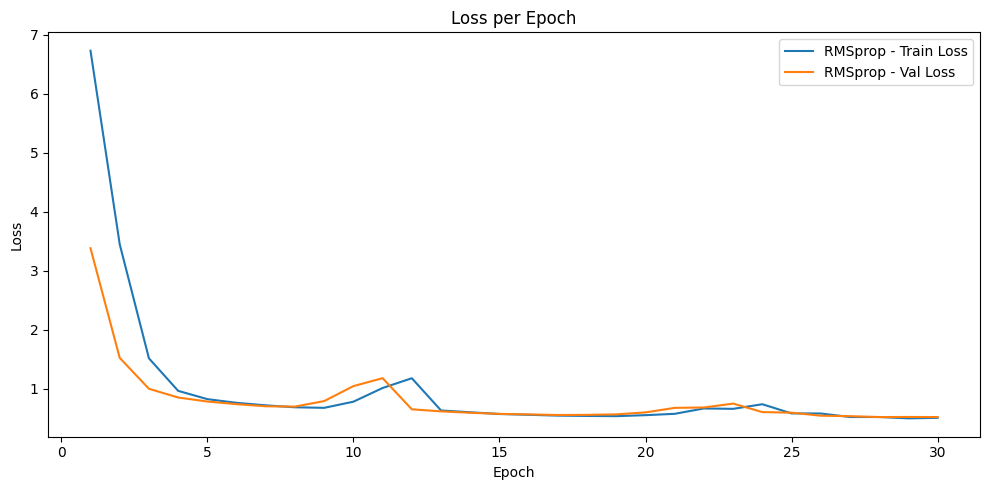

In [ ]:
# Assuming you have already trained your model and obtained the loss histories
adagrad_train_losses, adagrad_val_losses = adagrad_metrics
rmsprop_train_losses, rmsprop_val_losses = rmsprop_metrics

plot_losses(adagrad_train_losses, adagrad_val_losses, 'Adagrad')
plot_losses(rmsprop_train_losses, rmsprop_val_losses, 'RMSprop')


# Built-in: Adagrad and RMSProp

In [ ]:
# Train using Adagrad
net_adagrad_1 = RegressionNet()
net_adagrad_1 = net_adagrad_1.to(device)
opt = torch.optim.Adagrad(net_adagrad_1.parameters(), lr=0.01)
adagrad_metrics_1 = train_model(net_adagrad_1, trainloader, testloader, epochs=30, optimizer=opt)

Epoch 1/30, Training Loss: 6.6636, Validation Loss: 5.3531
Epoch 2/30, Training Loss: 5.4383, Validation Loss: 4.5406
Epoch 3/30, Training Loss: 4.6107, Validation Loss: 3.8246
Epoch 4/30, Training Loss: 3.8770, Validation Loss: 3.2136
Epoch 5/30, Training Loss: 3.2480, Validation Loss: 2.7019
Epoch 6/30, Training Loss: 2.7184, Validation Loss: 2.3018
Epoch 7/30, Training Loss: 2.3020, Validation Loss: 1.9993
Epoch 8/30, Training Loss: 1.9850, Validation Loss: 1.7710
Epoch 9/30, Training Loss: 1.7453, Validation Loss: 1.5971
Epoch 10/30, Training Loss: 1.5629, Validation Loss: 1.4623
Epoch 11/30, Training Loss: 1.4223, Validation Loss: 1.3563
Epoch 12/30, Training Loss: 1.3122, Validation Loss: 1.2707
Epoch 13/30, Training Loss: 1.2240, Validation Loss: 1.1996
Epoch 14/30, Training Loss: 1.1518, Validation Loss: 1.1399
Epoch 15/30, Training Loss: 1.0913, Validation Loss: 1.0885
Epoch 16/30, Training Loss: 1.0399, Validation Loss: 1.0446
Epoch 17/30, Training Loss: 0.9959, Validation Lo

In [ ]:
# Train using RMSprop
net_rmsprop_1 = RegressionNet()
net_rmsprop_1 = net_rmsprop_1.to(device)
opt = torch.optim.RMSprop(net_rmsprop_1.parameters(), lr=0.01)
rmsprop_metrics_1 = train_model(net_rmsprop_1, trainloader, testloader, epochs=30, optimizer=opt)

Epoch 1/30, Training Loss: 5.4964, Validation Loss: 32.0118
Epoch 2/30, Training Loss: 28.5077, Validation Loss: 4.7946
Epoch 3/30, Training Loss: 4.8695, Validation Loss: 4.0009
Epoch 4/30, Training Loss: 4.0599, Validation Loss: 3.2160
Epoch 5/30, Training Loss: 3.2562, Validation Loss: 2.4492
Epoch 6/30, Training Loss: 2.4671, Validation Loss: 1.7744
Epoch 7/30, Training Loss: 1.7695, Validation Loss: 1.2855
Epoch 8/30, Training Loss: 1.2626, Validation Loss: 1.0121
Epoch 9/30, Training Loss: 0.9795, Validation Loss: 0.8876
Epoch 10/30, Training Loss: 0.8527, Validation Loss: 0.8305
Epoch 11/30, Training Loss: 0.7983, Validation Loss: 0.7970
Epoch 12/30, Training Loss: 0.7696, Validation Loss: 0.7736
Epoch 13/30, Training Loss: 0.7503, Validation Loss: 0.7565
Epoch 14/30, Training Loss: 0.7352, Validation Loss: 0.7414
Epoch 15/30, Training Loss: 0.7216, Validation Loss: 0.7283
Epoch 16/30, Training Loss: 0.7093, Validation Loss: 0.7162
Epoch 17/30, Training Loss: 0.6979, Validation 

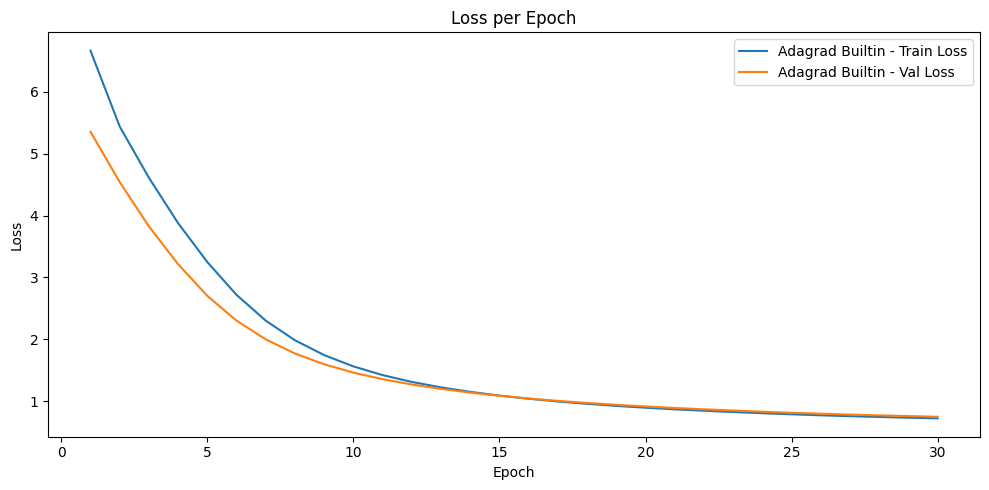

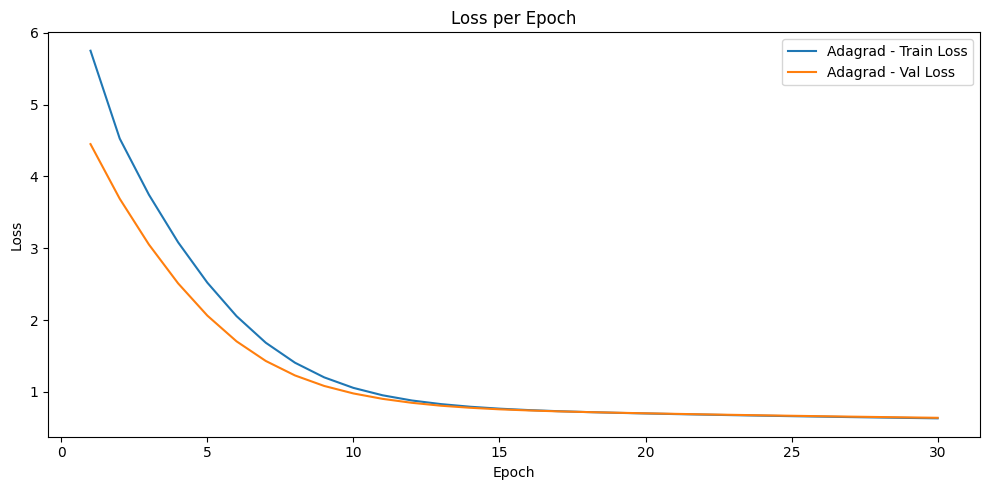

In [ ]:
# Assuming you have already trained your model and obtained the loss histories
adagrad_train_losses_1, adagrad_val_losses_1 = adagrad_metrics_1
adagrad_train_losses, adagrad_val_losses = adagrad_metrics

plot_losses(adagrad_train_losses_1, adagrad_val_losses_1, 'Adagrad Builtin')
plot_losses(adagrad_train_losses, adagrad_val_losses, 'Adagrad')


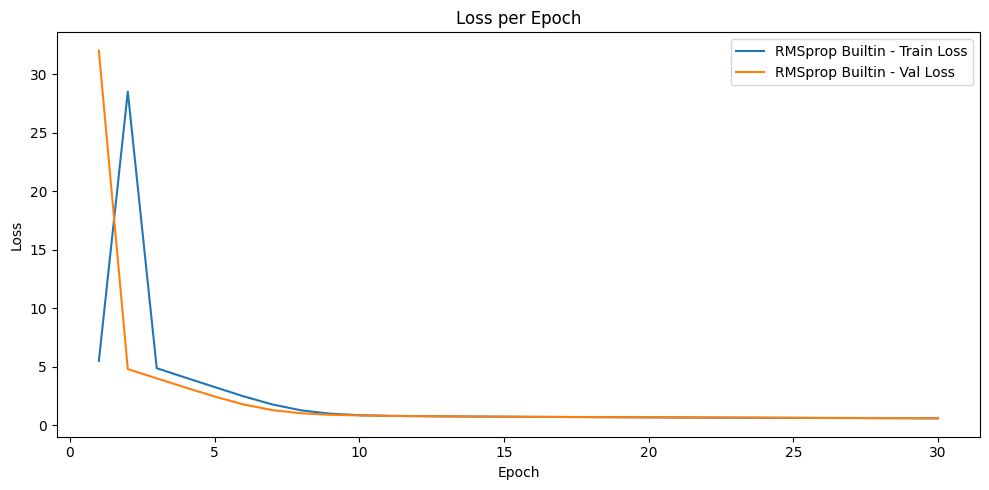

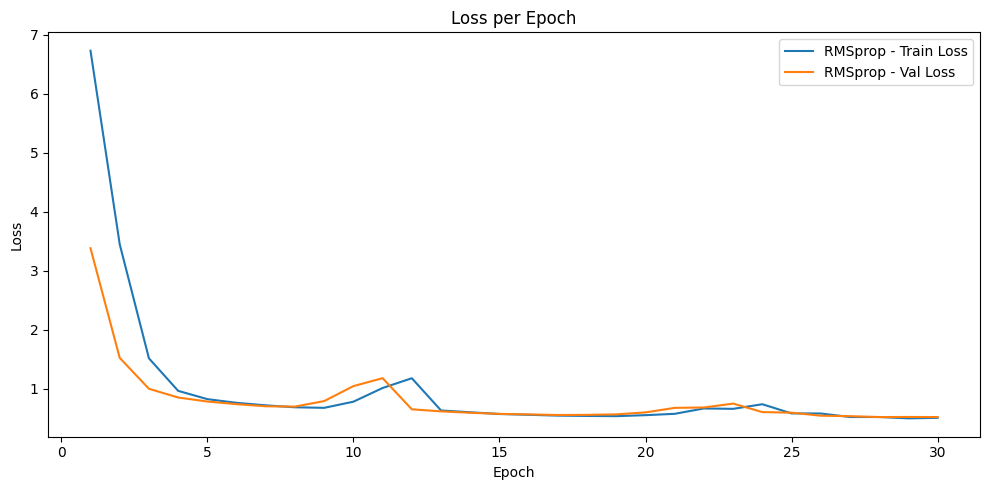

In [ ]:
# Assuming you have already trained your model and obtained the loss histories
rmsprop_train_losses_1, rmsprop_val_losses_1 = rmsprop_metrics_1
rmsprop_train_losses, rmsprop_val_losses = rmsprop_metrics

plot_losses(rmsprop_train_losses_1, rmsprop_val_losses_1, 'RMSprop Builtin')
plot_losses(rmsprop_train_losses, rmsprop_val_losses, 'RMSprop')
